# Gated recurrent unit
This structure introduces a 'gate' mechanism that enables the RNN to have the capability to remember or forget its previous state.
~~The gates one is reset gate which control the how many previous status to remember, the another is update gate, which means how many historical status we obtain into the next output.~~
One of the gates is the reset gate, which controls how much of the previous state to remember; another is the update gate, which determines how much of the historical state is incorporated into the next output.

~~The historical status marked as $\tilde(H_t)$, called candidate hidden state. Distinguished with the hidden state defined in RNN, the candidate hidden states are controlled by reset gate, to make sure only necessary states stored in hidden state.~~  
The historical state, marked as $\tilde{H_t}$ and called the candidate hidden state, is distinct from the hidden state defined in RNN. It is controlled by the reset gate to ensure that only necessary states are stored in the hidden state.

~~When updating the hidden state, GRU will update $H$ from last hiddens state and the candidate hiden state according to the update gate in different rights.~~  
When updating the hidden state, the GRU updates $H$ by combining the last hidden state and the candidate hidden state according to the update gate's instructions, allowing for a differential weighting of information.

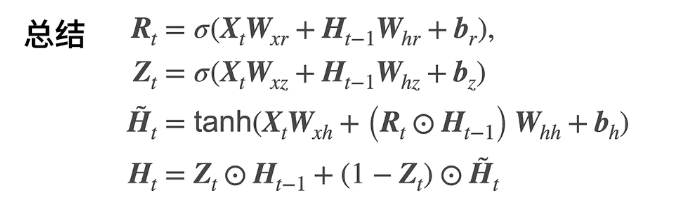

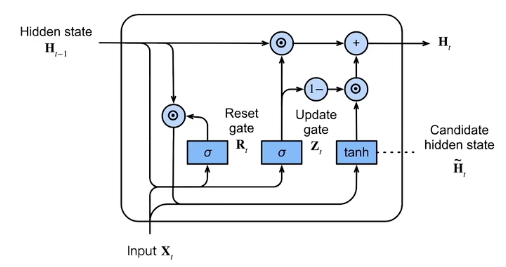

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from utils import load_data_time_machine, try_gpu
import utils

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [4]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

困惑度 1.1, 11146.6 词元/秒 mps
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


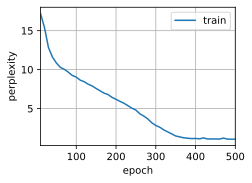

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1
model = utils.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
utils.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Using pytorch framework

困惑度 nan, 20795.8 词元/秒 mps
time traveller<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>
traveller<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>


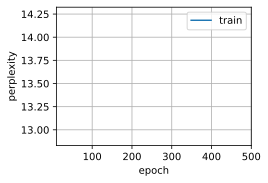

In [7]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1

num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = utils.RNNModel(gru_layer, len(vocab))
model = model.to(device)
utils.train_ch8(model, train_iter, vocab, lr, num_epochs, device)